In [55]:
from statsbombpy import sb
import pandas as pd

In [56]:
#find ids for barca home matches - only home games because then locations can be compared between different games
matches = sb.matches(competition_id=11, season_id=90)
barca_home_matches = matches[matches["home_team"]=="Barcelona"]
match_ids = barca_home_matches['match_id'].values.tolist()

C:\Users\thors\AppData\Roaming\Python\Python312\site-packages\statsbombpy\api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(


In [57]:
#All events sorted for barca home games and possession 
events = sb.competition_events(
    country="Spain",
    division= "La Liga",
    season="2020/2021",
    gender="male"
)
events = events[events['match_id'].isin(match_ids)]
df = events[events["team"]=="Barcelona"]
df = events[events["possession_team"]=="Barcelona"]

C:\Users\thors\AppData\Roaming\Python\Python312\site-packages\statsbombpy\api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(


In [58]:
#filter threshold for Xg:
df_xg = df[~df['shot_statsbomb_xg'].between(0, 0.05)]

In [59]:
#only include rows which has Xg/shot or a pass
df_shot_pass = df[df['type'].isin(['Shot', 'Pass', 'Carry'])]

In [60]:
#Events sorted in a specific order so each passing sequence is correctly sorted
sequences_sorted = df_shot_pass.sort_values(['match_id', 'period','timestamp'], ascending=[True, True, True])

In [61]:
#make new ids because right now there is ids from 1 to x for each match but it repeats from 1 and up in every match so each possession id points to different matches 
# - i just put the possession id after match_id in the newly created id
sequences_sorted['possession_id'] = sequences_sorted['match_id'].astype(str) + sequences_sorted['possession'].astype(str)
sequences_sorted['possession_id'] = sequences_sorted['possession_id'].astype(int)

C:\Users\thors\AppData\Local\Temp\ipykernel_7540\955078220.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sequences_sorted['possession_id'] = sequences_sorted['match_id'].astype(str) + sequences_sorted['possession'].astype(str)


In [62]:
#get the ids of sequences which contain a shot (contain an xg value)
shot_sequences = sequences_sorted[sequences_sorted["shot_statsbomb_xg"].notna()]
shot_sequences_ids = shot_sequences["possession_id"].unique()

In [63]:
#filter for possession sequences which end with a shot
sequences_filtered = sequences_sorted[sequences_sorted['possession_id'].isin(shot_sequences_ids)]

In [64]:
#fill all rows with an xg for the corresponding sequence - right now there are many missing values in "shot_statsbomb_xg"
sequences_filtered['xg'] = sequences_filtered.groupby('possession_id')['shot_statsbomb_xg'].transform(lambda group: group.fillna(method='ffill').fillna(method='bfill'))

C:\Users\thors\AppData\Local\Temp\ipykernel_7540\2851514471.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sequences_filtered['xg'] = sequences_filtered.groupby('possession_id')['shot_statsbomb_xg'].transform(lambda group: group.fillna(method='ffill').fillna(method='bfill'))
C:\Users\thors\AppData\Local\Temp\ipykernel_7540\2851514471.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sequences_filtered['xg'] = sequences_filtered.groupby('possession_id')['shot_statsbomb_xg'].transform(lambda group: group.fillna(method='ffill').fillna(method='bfill'))
C:\Users\thors\AppData\Local\Temp\ipykernel_7540\2851514471.py:2: SettingWithCopyWarning: 
A value is trying to be s

In [65]:
#now we dont need the shot event rows any more so remove them
sequences_filtered = sequences_filtered[sequences_filtered["type"]!="Shot"]

In [66]:
#make end location for passes and carries (start location has no missing values)
#combine the two types (pass and carry) into one location column (now we dont know if an edge is a pass or carry btw)
sequences_filtered['end_location'] = sequences_filtered['pass_end_location'].fillna(sequences_filtered['carry_end_location'])

C:\Users\thors\AppData\Local\Temp\ipykernel_7540\762106847.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sequences_filtered['end_location'] = sequences_filtered['pass_end_location'].fillna(sequences_filtered['carry_end_location'])


In [67]:
#assign x and y coordinates from location lists
sequences_filtered["start_x"] = sequences_filtered["location"].str[0]
sequences_filtered["start_y"] = sequences_filtered["location"].str[1]
sequences_filtered["end_x"] = sequences_filtered["end_location"].str[0]
sequences_filtered["end_y"] = sequences_filtered["end_location"].str[1]

C:\Users\thors\AppData\Local\Temp\ipykernel_7540\1692549575.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sequences_filtered["start_x"] = sequences_filtered["location"].str[0]
C:\Users\thors\AppData\Local\Temp\ipykernel_7540\1692549575.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sequences_filtered["start_y"] = sequences_filtered["location"].str[1]
C:\Users\thors\AppData\Local\Temp\ipykernel_7540\1692549575.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert

In [68]:
#reduce the number of possible x and y coordinates, essentially making the fields/nodes of the pitch larger
sequences_filtered['start_node_x'] = round(sequences_filtered['start_x'] / 20)
sequences_filtered['start_node_y'] = round(sequences_filtered['start_y'] / 20)
sequences_filtered['end_node_x'] = round(sequences_filtered['end_x'] / 20)
sequences_filtered['end_node_y'] = round(sequences_filtered['end_y'] / 20)

C:\Users\thors\AppData\Local\Temp\ipykernel_7540\3779965507.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sequences_filtered['start_node_x'] = round(sequences_filtered['start_x'] / 20)
C:\Users\thors\AppData\Local\Temp\ipykernel_7540\3779965507.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sequences_filtered['start_node_y'] = round(sequences_filtered['start_y'] / 20)
C:\Users\thors\AppData\Local\Temp\ipykernel_7540\3779965507.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of cal

In [69]:
#combine the x and y coordinates
sequences_filtered["start_node"] = sequences_filtered["start_node_x"] + sequences_filtered["start_node_y"] / 10
sequences_filtered["end_node"] = sequences_filtered["end_node_x"] + sequences_filtered["end_node_y"] / 10
sequences_filtered = sequences_filtered[["start_node","end_node","xg","possession_id"]]

C:\Users\thors\AppData\Local\Temp\ipykernel_7540\1117941376.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sequences_filtered["start_node"] = sequences_filtered["start_node_x"] + sequences_filtered["start_node_y"] / 10
C:\Users\thors\AppData\Local\Temp\ipykernel_7540\1117941376.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sequences_filtered["end_node"] = sequences_filtered["end_node_x"] + sequences_filtered["end_node_y"] / 10


In [70]:
#missing values in the end_node probably because some "carry_end_location" or "pass_end_location" has missing values - remove the rows with missing values
final_sequences = sequences_filtered.dropna(subset=['end_node'])

In [71]:
#remove edges between the same node if wanted
final_sequences = final_sequences[final_sequences['start_node'] != final_sequences['end_node']]

In [72]:
#remove sequences with few passes if wanted
index_counts = final_sequences['possession_id'].value_counts()
final_sequences = final_sequences[final_sequences['possession_id'].isin(index_counts[index_counts > 5].index)]

In [74]:
#get all the unique possession ids for iteration
possession_index = final_sequences["possession_id"].unique()

In [80]:
import networkx as nx

#iterate over possession ids and each row and append edges to a list for each graph and append that graph to a graphs dictionary (directed graph created with "nx.DiGraph(edges)")
#xg added as an attribute for each graph
graphs_dict = {}
for j in possession_index:
    edges = []
    for i in final_sequences.index:
        if j == final_sequences["possession_id"][i]:
            edges.append((final_sequences["start_node"][i], final_sequences["end_node"][i]))
            if j not in graphs_dict:
                graphs_dict[j] = {"xg": final_sequences["xg"][i], "graph": None}
            else:
                graphs_dict[j]["xg"] = final_sequences["xg"][i]
                
    graph = nx.DiGraph(edges)
    graphs_dict[j]["graph"] = graph

graph_list = [value["graph"] for value in graphs_dict.values()]

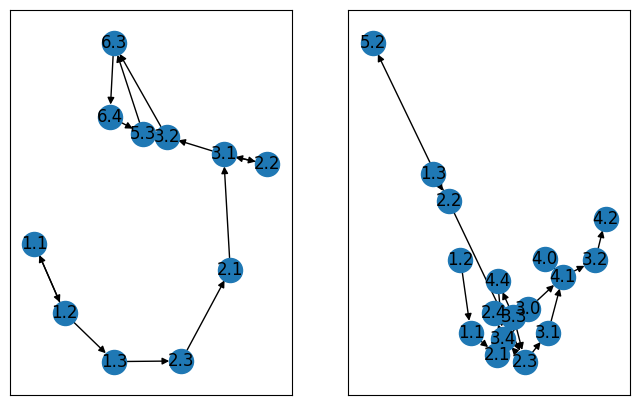

In [81]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.figure(1)

plt.subplot(1,2,1)
nx.draw_networkx(graphs_dict[37644403]["graph"])

plt.subplot(1,2,2)
nx.draw_networkx(graphs_dict[376444064]["graph"])

plt.show()